# HW04: RDD and Diff-in-Diff (due 26th October)

**You will have to solve only one of the two parts (either the RDD or the DiD) to get full credit for this homework.**

In this homework you will investigate the causal effect in two different settings, applying different **identification strategies**, You will also reflect and investigate the identification assumptions that allow for a causal interpretation. 

## Regression Discontinuity Design

In this first part you will use data on mayors from municipalities in Brazil to invesitgate th effect of electoral accountability on corruption. The goal is to estimate the effect of being eligible for reelection (having reelection incentives) on misappropriation of resources exploiting random audits on municipalities before the elections. In Brazil there is a two mandate limit for mayors, implying that only mayors in the first mandate can be reelected. The reference paper is [Ferraz and Finan (2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.4.1274).

In [1]:
import pandas as pd
import warnings
from rdrobust import rdrobust, rdbwselect, rdplot

warnings.filterwarnings('ignore')


In [2]:
df = pd.read_stata('data/HW04_data_rdd.dta')

In [3]:
df_labels = pd.read_stata('data/HW04_data_rdd.dta', iterator=True).variable_labels()

In [4]:
df = df[df['esample2']==1]
df.head()

,uf,nsorteio,totrecursos,tot_os,pop,purb,p_secundario,cod_ibge6,pib_capita_02,op_01_04,...,lfunc_ativ,lrec_fisc,ncorrupt,valor_corrupt,pcorrupt,dcorrupt,esample2,wm,winning_margin,party
0,RO,5,6913597.38,47.0,18207,0.815401,0.248250,566128.0,3548.000977,0,...,6.167517,15.749001,3.0,672785.125,0.097313,1.0,1.0,0.030935,-0.030935,16
1,RO,7,7135210.78,62.0,10459,0.198203,0.110925,566130.0,4203.421875,0,...,5.641907,15.780552,0.0,0.000,0.000000,0.0,1.0,0.172863,0.172863,3
2,RO,2,26821074.06,140.0,40884,0.649178,0.254702,566138.0,3904.267334,0,...,6.872128,17.104698,1.0,0.000,0.000000,1.0,1.0,0.310956,0.310956,18
3,RO,4,14710780.70,89.0,47382,0.726457,0.267212,566151.0,4081.257812,0,...,6.979145,16.504091,0.0,0.000,0.000000,0.0,1.0,0.391912,0.391912,18
4,RO,3,4181534.83,NaN,23874,0.271257,0.134546,566155.0,2192.473633,1,...,6.118097,15.246189,0.0,0.000,0.000000,0.0,1.0,0.186155,0.186155,14


The main outcome of interest is *pcorrupt*, namely, the share of audited resources found that involve corruption (a measure of misappropriation). The explanatory variable is *first*, a dummy variable indicating whether the mayor is in his first mandate. The regression of interest is the following: 

<center>$pcorrupt_i = \beta_0 + \beta_1 first_i + \varepsilon_i$</center>

In [5]:
## run the regression above using robust standard errors
import statsmodels.formula.api as smf 
from statsmodels.iolib.summary2 import summary_col

ols1 = smf.ols(formula="pcorrupt ~ first", data=df).fit(cov_type='HC1')

**What could be some sources of bias, namely, variables that act as confounder?**

An example of confounder could be mayor experience. Indeed, less experienced mayors, more likely to be in their first mandate, may be also more likely to be involed in corruption activities because of their lack of experience.

In [8]:
## run the regression above adding the variables that may act as a confounder
ols2 = smf.ols(formula="pcorrupt ~ first + C(party) + lpop + purb + p_secundario + mun_novo + gini_ipea", data=df).fit(cov_type='HC1')

In [11]:
## display the results
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pcorrupt   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.943
Date:                Thu, 16 Mar 2023   Prob (F-statistic):             0.0476
Time:                        21:31:21   Log-Likelihood:                 415.01
No. Observations:                 476   AIC:                            -826.0
Df Residuals:                     474   BIC:                            -817.7
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0737      0.007     10.039      0.000       0.059       0.088
first         -0.0188      0.009     -1.986      0.047      -0.037      -0.000
==============================================================================
Omnibus:                      318.592   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3161.573
Skew:                           2.874   Prob(JB):                         0.00
Kurtosis:                      14.242   Cond. No.                         2.81
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [10]:
## display the results
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pcorrupt   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     173.5
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          1.42e-197
Time:                        21:31:18   Log-Likelihood:                 431.79
No. Observations:                 476   AIC:                            -815.6
Df Residuals:                     452   BIC:                            -715.6
Df Model:                          23                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1516      0.068      2.234      0.025       0.019       0.285
C(party)[T.10]    -0.0009      0.021     -0.043      0.966      -0.042       0.040
C(party)[T.11]     0.0166      0.014      1.215      0.224      -0.010       0.043
C(party)[T.12]     0.0796      0.056      1.429      0.153      -0.030       0.189
C(party)[T.13]    -0.0160      0.012     -1.342      0.180      -0.039       0.007
C(party)[T.14]    -0.0107      0.013     -0.825      0.409      -0.036       0.015
C(party)[T.15]     0.2865      0.015     19.582      0.000       0.258       0.315
C(party)[T.16]     0.0309      0.031      0.996      0.319      -0.030       0.092
C(party)[T.17]     0.0580      0.016      3.654      0.000       0.027       0.089
C(party)[T.18]     0.0305      0.016      1.945      0.052      -0.000       0.061
C(party)[T.2]      0.0652      0.025      2.580      0.010       0.016       0.115
C(party)[T.3]      0.0219      0.016      1.397      0.163      -0.009       0.053
C(party)[T.4]      0.0335      0.021      1.631      0.103      -0.007       0.074
C(party)[T.5]      0.0303      0.022      1.354      0.176      -0.014       0.074
C(party)[T.6]      0.0509      0.016      3.111      0.002       0.019       0.083
C(party)[T.7]      0.2151      0.014     15.360      0.000       0.188       0.243
C(party)[T.8]      0.0731      0.035      2.062      0.039       0.004       0.143
C(party)[T.9]      0.0474      0.032      1.471      0.141      -0.016       0.110
first             -0.0186      0.010     -1.833      0.067      -0.038       0.001
lpop              -0.0058      0.006     -0.896      0.370      -0.018       0.007
purb               0.0586      0.029      2.009      0.044       0.001       0.116
p_secundario      -0.1415      0.063     -2.231      0.026      -0.266      -0.017
mun_novo          -0.0017      0.015     -0.120      0.904      -0.030       0.027
gini_ipea         -0.0896      0.077     -1.157      0.247      -0.241       0.062
==============================================================================
Omnibus:                      327.274   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3809.824
Skew:                           2.907   Prob(JB):                         0.00
Kurtosis:                      15.581   Cond. No.                         243.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

**In your opinion, are there any additional sources of bias that threatens the causal interpretation of the results?**

Additional sources of bias could definitely be available such as the education level of the candidate elected and the previous experience of the cadidate. This might not be reflected on the data collected.

To make sure that this is not the case we will use a regression discontinuity design where the running variable is the margin by which the incumbent won or lost in the previous election. Namely, we compare municipalities where incumbents won or lost by a narrow margin. This comparison provides quasi-random assignment of first-term and second-term mayors across these competitive elections.

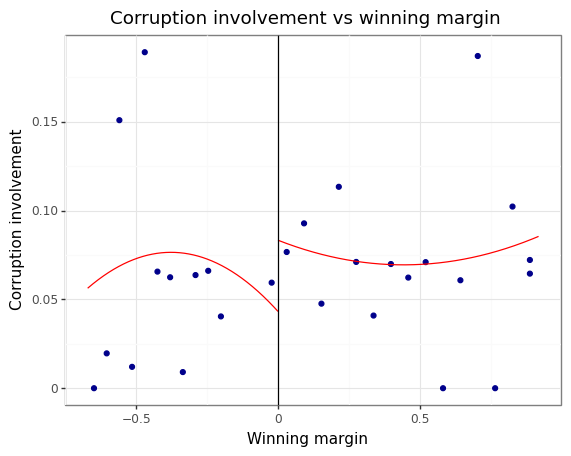


Call: rdplot
Number of Observations:                   328
Kernel:                               Uniform
Polynomial Order Est. (p):                  2

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Effective Obs          126        202
Bandwith poly. fit (h)         0.671      0.918
Number of bins scale               1          1
Bins Selected                     15         15
Average Bin Length             0.048      0.061
Median Bin Length              0.045      0.061
IMSE-optimal bins                5.0        3.0
Mimicking Variance bins         15.0       11.0

Relative to IMSE-optimal:
Implied scale                    3.0        5.0
WIMSE variance weight          0.036      0.008
WIMSE bias weight              0.964      0.992


In [12]:
## plot the RD plot using as running variable the variable winning_margin
## use a second order polynomial and 15 bins at each side

margin = df.dropna(subset=['winning_margin']).winning_margin
corruption = df.dropna(subset=['winning_margin']).pcorrupt

rdplot(y=corruption, x=margin, nbins=15, masspoints='adjust', p=2,
         title="Corruption involvement vs winning margin", 
         y_label="Corruption involvement",
         x_label=" Winning margin")

In [13]:
## run the RD regression using the same dependent and explanatory variable as before
## include 4th degree polynomial and the covariates that you included above
covs = pd.concat([df.dropna(subset=['winning_margin'])['wm']], axis=1)

for y in covs:
    print(rdrobust(y=corruption, x=margin, covs = covs, p=4, vce='hc1'))

Call: rdrobust
Number of Observations:                   328
Polynomial Order Est. (p):                  4
Polynomial Order Bias (q):                  5
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Unique Obs.            126        201
Number of Effective Obs.          94        124
Bandwidth Estimation           0.202      0.202
Bandwidth Bias                  0.27       0.27
rho (h/b)                      0.746      0.746

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.031    0.042    0.727   4.672e-01    [-0.052, 0.113]
Robust                 -        -    0.897   3.697e-01    [-0.046, 0.124]



**Interpret the coefficient**
On average, first term mayors misappropriate lesser with respect to incumbent mayors, meaning that having electoral incentives decreases the likelihood of misappropriation. Note that here the coefficient is not statistically significant because it only includes a subset of covariates, while in the paper they include almost all of them.



## Difference-in-Differences

In this part you will use data from Argentina to investigate the causal effect of police on crime. Following the paper by [Di Tella and Schargrodsky (2004)](https://www.aeaweb.org/articles?id=10.1257/000282804322970733), you will exploit the follow-up of a terrorist attack tto the Jewish center in Buenos Aires in July 1994, after which all Jewish institution received police protection. This event induced a geographical allocation of police forces orthogonal to a crime regression allowing to isolate the causal effect of having more police in a neighborhood on a proxy for crime (car thefts), through a difference-in-differences analysis. 

In [15]:
df = pd.read_stata('data/HW04_data_DiD.dta')
df_labels = pd.read_stata('data/HW04_data_DiD.dta', iterator=True).variable_labels()

In [16]:
df.head()

,observ,barrio,calle,altura,institu1,institu3,distanci,edpub,estserv,banco,totrob,mes,inst3_1,month5,post,inst1p,inst3_1p
0,870.0,Once,Cordoba,a2300,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
1,851.0,Once,Tucuman,a2400,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,843.0,Once,Lavalle,a2300,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
3,796.0,Once,Pasteur,a500,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
4,790.0,Once,Azcuenaga,a700,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


The main outcome of interest is *totrob*, the total number of car thefts (proxy for criminal activity). The main explanatory variable is a dummy variable indicating whether the there is a Jewish institution in the neighborhood **and** the observation is after July (*inst1p*). The main regression is the following: 

<center>$totrob_i = \beta_0 + \beta_1 inst1p_i + \varepsilon_i$</center>

In [18]:
## Run the regression above with robust standard errors
import statsmodels.formula.api as smf

ols1 = smf.ols('totrob ~ inst1p', data=df).fit(cov_type='HC1')

**Why this estimate CANNOT be interpreted as causal?**

There are unobserved confounders - Jewish institution could display less crime even before terrorist attacks.

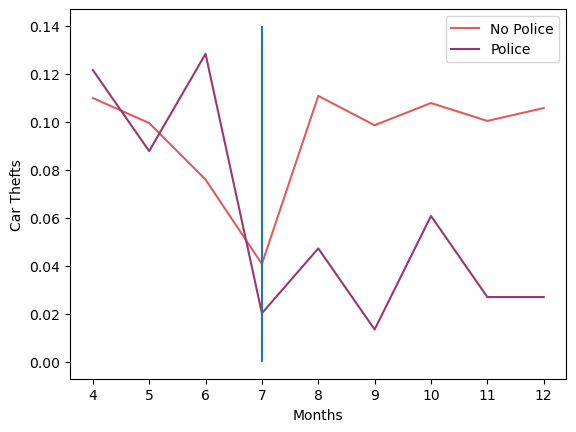

In [19]:
## Plot the time series of car thefts separately for blocks with and without a jewish institutions
## Add a vertical line indicating the terrorist attack 
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("flare", 2)
plot = sns.lineplot(data=df, x='mes', y='totrob', hue='institu1', palette=palette, ci=None)
plot.set(xlabel='Months', ylabel='Car Thefts')
plot.legend_.set_title('')
new_labels = ['No Police', 'Police']
for t, l in zip(plot.legend_.texts, new_labels):
    t.set_text(l)
plt.vlines(7, 0, 0.14)
plt.show()

**Does the parallel trend assumption hold?**

It does, however, in the graph it is not that evident. In the paper, they test this by running a regression of car thefts on a dummy for a Jewish institution in the period before the attack and find no statistically significant difference between different neihborhood, suggesting that the parallel trends assumption holds.

In [21]:
##Run the regression above including month and block fixed effects
from linearmodels import PanelOLS
df_did = df.set_index(['observ', 'mes'])
did = PanelOLS(df_did.totrob, df_did.inst1p, entity_effects=True, time_effects=True).fit(cov_type = 'clustered', cluster_entity=True)

In [22]:
##show the results from both regressions
ols1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 totrob   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     32.75
Date:                Thu, 16 Mar 2023   Prob (F-statistic):           1.09e-08
Time:                        21:38:44   Log-Likelihood:                 4.5306
No. Observations:                7884   AIC:                            -5.061
Df Residuals:                    7882   BIC:                             8.884
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0943      0.003     33.943      0.000       0.089       0.100
inst1p        -0.0592      0.010     -5.723      0.000      -0.079      -0.039
==============================================================================
Omnibus:                     5778.589   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            81436.831
Skew:                           3.518   Prob(JB):                         0.00
Kurtosis:                      17.085   Cond. No.                         6.61
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [23]:
did

Dep. Variable:,totrob,R-squared:,0.0013
Estimator:,PanelOLS,R-squared (Between):,-0.0149
No. Observations:,7884,R-squared (Within):,0.0005
Date:,"Thu, Mar 16 2023",R-squared (Overall):,-0.0040
Time:,21:38:14,Log-likelihood,870.52
Cov. Estimator:,Clustered,,
,,F-statistic:,8.9506
Entities:,876,P-value,0.0028
Avg Obs:,9.0000,Distribution:,"F(1,6999)"
Min Obs:,9.0000,,
Max Obs:,9.0000,F-statistic (robust):,9.6788


**Compare and interpret the results**

The coefficient from the diff-in-diff is larger in magnitude, implying that there are some pre-determined differences between blocks or the two periods that lead to a downward bias of the estimate. The coefficient from the diff-in-diff implies that on average, blocks with a Jewish institution after the terrorist attack display 0.0775 less car thefts than blocks with no Jewish institution before the attack.

This number may not seem meaningful by itself, so what it is often done in empirical analysis is to assess the magnitude looking at the average value of the dependent variable. In this case, the post-attack average number of monthly car thefts is 0.108. Therefore, we can interpret the coefficient as a 70% decrease in crime due to higher police presence, with respect to the average crime level in that period.